In [1]:
import os
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark
import boto3

role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# See the SageMaker Spark Github repo under sagemaker-pyspark-sdk
# to learn how to connect to a remote EMR cluster running Spark from a Notebook Instance.
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath).getOrCreate()
#spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath).master("local[*]").getOrCreate()

import pandas as pd
import numpy as np
import re
import sys
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

batch_size = 126

### 1: Train Model with Behavior and Content Data with 5 Layers

In [3]:
#df_train = spark.read.format('parquet').load('s3a://fetch-data-puddle/spark/sandbox/mingjun/ORtrain/').sample(0.01)
#df_test = spark.read.format('parquet').load('s3a://fetch-data-puddle/spark/sandbox/mingjun/ORtest/')
def read_prefix_to_df(prefix):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket('fetch-data-puddle')
    prefix_objs = bucket.objects.filter(Prefix=prefix)
    prefix_df = []
    for obj in prefix_objs:
        key = obj.key
        prefix_df.append(key)
        #body = obj.get()['Body'].read()
        #df = pd.DataFrame(body)
        #prefix_df.append(df)
    #return pd.concat(prefix_df)
    return prefix_df
read_prefix_to_df('spark/sandbox/mingjun/ORtrainCSV')

['spark/sandbox/mingjun/ORtrainCSV/_SUCCESS',
 'spark/sandbox/mingjun/ORtrainCSV/part-00000-ace753b3-99a7-4b7d-9208-2db591cf18bd-c000.csv']

In [4]:
def DowloandfileS3(inpt, out):
    bucketname = 'fetch-data-puddle' # replace with your bucket name
    s3 = boto3.resource('s3')
    s3.Bucket(bucketname).download_file(inpt, out)
path_train = read_prefix_to_df('spark/sandbox/mingjun/ORtrainCSV')[1]
print (path_train)
DowloandfileS3(path_train,'../train.csv')

path_test = read_prefix_to_df('spark/sandbox/mingjun/ORtestCSV')[1]
print (path_test)
DowloandfileS3(path_test,'../test.csv')

path_other = read_prefix_to_df('spark/sandbox/mingjun/ORotherCSV')[1]
print (path_other)
DowloandfileS3(path_other,'../other.csv')

spark/sandbox/mingjun/ORtrainCSV/part-00000-ace753b3-99a7-4b7d-9208-2db591cf18bd-c000.csv
spark/sandbox/mingjun/ORtestCSV/part-00000-4937e451-82b7-4161-986f-daf792106165-c000.csv
spark/sandbox/mingjun/ORotherCSV/part-00000-16c7370a-bcf8-43d3-b71f-722526f462c2-c000.csv


In [8]:
train = pd.read_csv('../train.csv', header=0)

test = pd.read_csv('../test.csv', header=0)
print (test.columns)

other = pd.read_csv('../other.csv', header=0)
print (other.columns)

print (train.shape)
print (test.shape)
print (other.shape)

Index(['user_id', 'offer_id', 'redeem_date', 'cat_brand_sums[0]',
       'cat_brand_sums[1]', 'cat_brand_sums[2]', 'cat_brand_sums[3]',
       'cat_brand_sums[4]', 'cat_brand_sums[5]', 'cat_brand_sums[6]',
       ...
       'id_catBrd_1081', 'id_catBrd_1082', 'id_catBrd_1083', 'id_catBrd_1084',
       'id_catBrd_1085', 'id_catBrd_1086', 'id_catBrd_1087', 'id_catBrd_1088',
       'id_catBrd_1089', 'target'],
      dtype='object', length=2287)
Index(['user_id', 'offer_id', 'redeem_date', 'facebook_authhot_[0]',
       'facebook_authhot_[1]', 'google_authhot_[0]', 'google_authhot_[1]',
       'statehot_[0]', 'statehot_[1]', 'statehot_[2]', 'statehot_[3]',
       'statehot_[4]', 'statehot_[5]', 'statehot_[6]', 'statehot_[7]',
       'statehot_[8]', 'statehot_[9]', 'statehot_[10]', 'statehot_[11]',
       'statehot_[12]', 'statehot_[13]', 'statehot_[14]', 'statehot_[15]',
       'statehot_[16]', 'statehot_[17]', 'statehot_[18]', 'statehot_[19]',
       'statehot_[20]', 'statehot_[21]', 'sta

In [9]:
other_keep = ['user_id', 'offer_id', 'redeem_date', 'facebook_authhot_[0]', 'facebook_authhot_[1]', 'google_authhot_[0]', 'google_authhot_[1]', 'statehot_[0]', 
              'statehot_[1]', 'statehot_[2]', 'statehot_[3]', 'statehot_[4]', 'statehot_[5]', 'statehot_[6]', 'statehot_[7]', 'statehot_[8]', 'statehot_[9]', 
              'statehot_[10]', 'statehot_[11]', 'statehot_[12]', 'statehot_[13]', 'statehot_[14]', 'statehot_[15]', 'statehot_[16]', 'statehot_[17]', 'statehot_[18]', 
              'statehot_[19]', 'statehot_[20]', 'statehot_[21]', 'statehot_[22]', 'statehot_[23]', 'statehot_[24]', 'statehot_[25]', 'statehot_[26]', 'statehot_[27]', 
              'statehot_[28]', 'statehot_[29]', 'statehot_[30]', 'statehot_[31]', 'statehot_[32]', 'statehot_[33]', 'statehot_[34]', 'statehot_[35]', 'statehot_[36]', 
              'statehot_[37]', 'statehot_[38]', 'statehot_[39]', 'statehot_[40]', 'statehot_[41]', 'statehot_[42]', 'statehot_[43]', 'statehot_[44]', 'statehot_[45]', 
              'statehot_[46]', 'statehot_[47]', 'statehot_[48]', 'statehot_[49]', 'statehot_[50]', 'statehot_[51]', 'statehot_[52]', 'alcohot_[0]', 'alcohot_[1]', 
              'value', 'life', 'age','user_age']

other = other[other_keep]
print (other.shape)
print (train.shape)
display(other.head(5))

(67261, 66)
(60480, 2287)


,user_id,offer_id,redeem_date,facebook_authhot_[0],facebook_authhot_[1],google_authhot_[0],google_authhot_[1],statehot_[0],statehot_[1],statehot_[2],...,statehot_[49],statehot_[50],statehot_[51],statehot_[52],alcohot_[0],alcohot_[1],value,life,age,user_age
0,57d4d05ae4b0a807bde28019,5dd4305ba2e51b3e0e91d85d,2019-11-21,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,2,43
1,59b372d7e4b08eb3b4028787,5dd439cb41cfc43b0e7a1407,2019-11-21,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,2,43
2,59c048a3e4b01ead606c78ae,5e128f5f56b90222fc2548b3,2020-02-05,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.5,28,29,42
3,59d5648fe4b0bf935cf6e235,5d937813eca44d1154639bc8,2019-10-22,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.5,20,21,38
4,59f72499e4b008f419dd15b8,5dc59366ace420773fa5d66c,2019-11-30,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.5,16,17,57


In [10]:
#x_train, x_test, y_train, y_test = train_test_split(train.drop(train.columns[]).values.astype(float), train[[u'target']].values, test_size=0.10, random_state=100)

train = pd.merge(other, train, on=['user_id', 'offer_id', 'redeem_date'],how='right').fillna(0)
test = pd.merge(other, test, on=['user_id', 'offer_id', 'redeem_date'],how='right').fillna(0)
print (train.columns)
print (train.shape)

Index(['user_id', 'offer_id', 'redeem_date', 'facebook_authhot_[0]',
       'facebook_authhot_[1]', 'google_authhot_[0]', 'google_authhot_[1]',
       'statehot_[0]', 'statehot_[1]', 'statehot_[2]',
       ...
       'id_catBrd_1081', 'id_catBrd_1082', 'id_catBrd_1083', 'id_catBrd_1084',
       'id_catBrd_1085', 'id_catBrd_1086', 'id_catBrd_1087', 'id_catBrd_1088',
       'id_catBrd_1089', 'target'],
      dtype='object', length=2350)
(60480, 2350)


In [11]:
X_vars = list(train.columns[3:-1])
#print (len(X_vars))
x_train, x_test, y_train, y_test = train_test_split(train[X_vars].values, train[list(train.columns)[-1]].values, test_size=0.10, random_state=100)
print (x_train.shape)
print (y_train.shape)
n_columns = x_train.shape[1]

(54432, 2346)
(54432,)


In [8]:
class ORDataset(Dataset):
    ## Define the underline data source
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx]), torch.tensor(self.y[idx])
        
dataset_train = ORDataset(x_train, y_train)

print ('Number of training set: ', len(dataset_train))
dataLoader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1)

dataset_test = ORDataset(x_test, y_test)
print ('Number of test data set: ', len(dataset_test))
dataLoader_test = DataLoader(dataset_test, batch_size=len(y_test), shuffle=True, num_workers=1)

Number of training set:  54432
Number of test data set:  6048


In [14]:
if torch.cuda.is_available():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
### Define the model components
class OfferRec(nn.Module):
    def __init__(self, input_size, layers=5):
        super(OfferRec, self).__init__()
        
        ##In this model, I am just using the several fc layers. the last layers is a scalar and through a sigmoid trnsformation.
        dim_layers = []
        
        
        for i in range(layers):
            dim_layers.append(input_size // 2**i )
        print ('Layer distribution: ', dim_layers)
        
        fc_blocks = [self.block(i, j) for i, j in zip(dim_layers, dim_layers[1:])]
        
        self.mc = nn.Sequential(*fc_blocks)
        
        self.linear = nn.Linear(dim_layers[-1], 1)
    
    def block(self, inpt, out):
        return nn.Sequential (
            nn.Linear(inpt, out),
            nn.ReLU()
            )

    def forward(self, x):
        ## x is the input tensor data
        
        out = self.mc(x)
        out = self.linear(out)
        out = torch.sigmoid(out)

        return out

loss_fn = nn.MSELoss()

model = OfferRec(n_columns).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)



Layer distribution:  [2346, 1173, 586, 293, 146]


epoch  10 loss:  2.684278985094352
epoch  20 loss:  1.6259082393605695
epoch  30 loss:  1.366502649136791
epoch  40 loss:  0.8702043774917598
epoch  50 loss:  0.8017300113211325
epoch  60 loss:  0.9187509618001677
epoch  70 loss:  0.8385194476739883
epoch  80 loss:  0.7798511460030468
epoch  90 loss:  0.5855417911077727
epoch  100 loss:  0.7071591712291951


Text(0, 0.5, 'MSE')

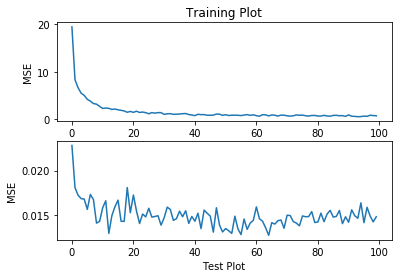

In [11]:
#list_users_train, list_items_train, list_labels_train, list_cats_train, list_manus_train,list_states_train

losses = []
losses_test = []

j= 0
for epoch in range(100):
    model.train()
    total_loss = 0
    for x, y in dataLoader_train:        
        x, y = x.to(device), y.to(device)
        model.zero_grad()

        pred_prob = model(x.float())
        loss = loss_fn(pred_prob, y.float().reshape(x.shape[0],1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    j=j+1
    if j % 10 == 0:
        print ('epoch ' , j, 'loss: ', total_loss)

    losses.append(total_loss)

    with torch.no_grad():
        model.eval()
        for x_t, y_t in dataLoader_test:
            x_t, y_t = x_t.to(device), y_t.to(device)
            pred_prob_test = model(x_t.float())
            loss_test = loss_fn(pred_prob_test, y_t.float().reshape(x_t.shape[0],1))
            loss_test = loss_test.item()
        losses_test.append(loss_test)

plt.subplot(2, 1, 1)
plt.plot(losses)
plt.title('Training Plot')
plt.ylabel('MSE')

plt.subplot(2, 1, 2)
plt.plot(losses_test)
plt.xlabel('Test Plot')
plt.ylabel('MSE')



In [12]:
#Save ghe model
torch.save(model.state_dict(),'../mode_other.tp')
the_model = OfferRec(n_columns)
#the_model.load_state_dict(torch.load(PATH))

Layer distribution:  [2346, 1173, 586, 293, 146]


### Performance on the test dataset

Index(['user_id', 'offer_id', 'redeem_date', 'facebook_authhot_[0]',
       'facebook_authhot_[1]', 'google_authhot_[0]', 'google_authhot_[1]',
       'statehot_[0]', 'statehot_[1]', 'statehot_[2]',
       ...
       'id_catBrd_1081', 'id_catBrd_1082', 'id_catBrd_1083', 'id_catBrd_1084',
       'id_catBrd_1085', 'id_catBrd_1086', 'id_catBrd_1087', 'id_catBrd_1088',
       'id_catBrd_1089', 'target'],
      dtype='object', length=2350)
(6781, 2346)
Layer distribution:  [2346, 1173, 586, 293, 146]
torch.Size([6781, 1])


,prob,target
0,1.293028e-14,0.0
1,1.000000e+00,1.0
2,1.832366e-07,0.0
3,1.083977e-07,0.0
4,3.009597e-06,0.0


   rank  cnt          prob  target
9     9  678  7.446672e-01   500.0
8     8  678  1.574449e-04    12.0
7     7  678  5.392464e-06     0.0
6     6  678  1.471763e-06     1.0
5     5  678  4.981808e-07     1.0
4     4  678  1.443293e-07     1.0
3     3  678  3.077625e-08     3.0
2     2  678  3.250203e-09     0.0
1     1  678  2.972582e-11     1.0
0     0  679  1.503364e-15     3.0


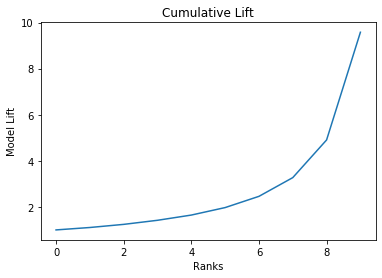

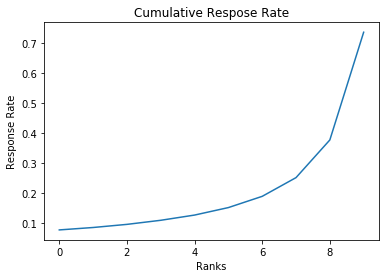

In [17]:
print (test.columns)
print (test.values[:,3:-1].shape)
X_test_tensor = torch.from_numpy(test.values[:,3:-1].astype(float)).float()
y_test_tensor = torch.from_numpy(test['target'].values)

with torch.no_grad():
    model = OfferRec(test.values[:,3:-1].shape[1])
    model.load_state_dict(torch.load('../mode_other.tp'))
    model.eval()
    pred_prob = model(X_test_tensor)
    print (pred_prob.shape)
    pred = pd.DataFrame(torch.cat((pred_prob, y_test_tensor.float().reshape(-1,1)), 1).numpy(), columns = ['prob', 'target'])
display(pred.head(n=5))

from imp import reload 
import Model
reload(Model)

Lift = Model.ModelLift(c=10)
lift = Lift.calLift(pred, target='target', prob='prob')
Model.Plot(lift)

### 2: Test RandomForest and Logistic Regression Performace on the same amount of the data

In [44]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as LR
rfc = RFC(n_estimators = 100)
rfc.fit(x_train, y_train)

logit=LR(solver='liblinear',max_iter = 300)
logit.fit(x_train,y_train)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [17]:
import pickle
pickle.dump(rfc, open('../model_rfc.p','wb'))

In [26]:
rfc = pickle.load(open('../model_rfc.p', 'rb'))
pred = rfc.predict_proba(x_test)[:,1]
pred_test = rfc.predict_proba(test[X_vars])[:,1]

#### 2.1: Performance of Random Forest 

   rank   cnt      prob  target
6     6   334  0.830569     329
5     5   338  0.543432     184
4     4   334  0.153323       9
3     3   271  0.047417       0
2     2   206  0.030000       0
1     1   334  0.020000       0
0     0  4964  0.001547       0


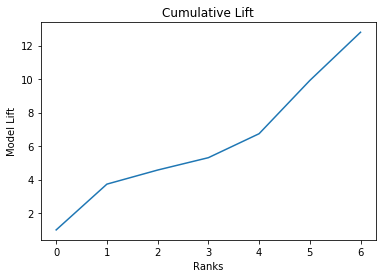

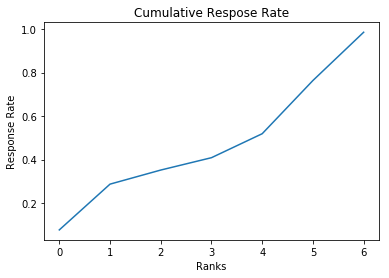

In [41]:
from imp import reload 
import Model
reload(Model)

test['prob'] = pred_test
#print (test.sort_values(by='prob', ascending = False)[0:100][['prob']])

Lift = Model.ModelLift(c=20)
lift = Lift.calLift(test, target='target', prob='prob')
Model.Plot(lift)

#### 2.2: Performace of Logistic Regression

    rank  cnt      prob  target
19    19  339  0.995421     336
18    18  339  0.336955     131
17    17  339  0.077836       9
16    16  339  0.051937       8
15    15  339  0.039234       6
14    14  339  0.030641       4
13    13  339  0.025460       3
12    12  339  0.021496       2
11    11  339  0.018406       0
10    10  339  0.015672       2


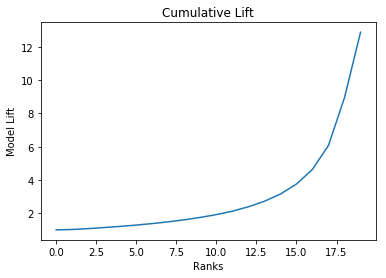

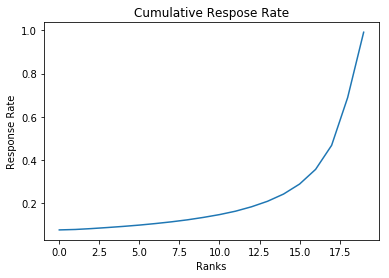

In [46]:
pred_test = logit.predict_proba(test[X_vars])[:,1]

from imp import reload 
import Model
reload(Model)

test['prob'] = pred_test
#print (test.sort_values(by='prob', ascending = False)[0:100][['prob']])

Lift = Model.ModelLift(c=20)
lift = Lift.calLift(test, target='target', prob='prob')
Model.Plot(lift)